## Prepare

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read in all the words
words = open('data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = { ch: i for i, ch in enumerate(chars) }
# stoi['.'] = 0
itos = { i: ch for ch, i in stoi.items() }
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [7]:
# build the dataset
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Test

In [79]:
 X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [29]:
emb_size = 2
C = torch.randn((27,emb_size))

In [30]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [31]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [32]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [33]:
# torch.cat(torch.unbind(emb, 1),dim=1).shape

torch.Size([32, 6])

In [43]:
## more efficient way to reshape is using tensor.view
## no memory is copied, just a different view of the same data
## tensor data is stored in a contiguous chunk of memory, always 1 dimensional
h = torch.tanh(emb.view(-1, block_size*emb_size) @ W1 + b1)
## make h value between -1 and 1

In [44]:
h

tensor([[-0.8469, -0.4142,  0.9962,  ..., -0.5987,  0.6432,  0.9443],
        [-0.3849, -0.8208,  0.9584,  ..., -0.8597,  0.7771,  0.8581],
        [-0.9765,  0.1696,  0.9827,  ..., -0.4787,  0.7010, -0.0858],
        ...,
        [-0.0413,  0.9673,  0.9382,  ..., -0.9994,  0.9912,  0.7530],
        [-0.9846, -0.9542,  0.9994,  ...,  0.6752, -0.6631,  0.9382],
        [ 0.9993, -0.9363, -0.9886,  ..., -0.9999,  0.9996,  0.6244]])

In [35]:
h.shape

torch.Size([32, 100])

In [45]:
## second layer
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [46]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [47]:
counts = logits.exp()

In [48]:
prob = counts / counts.sum(dim=1, keepdim=True)

In [49]:
prob.shape

torch.Size([32, 27])

In [54]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.0671)

In [52]:
prob[torch.arange(32), Y]

tensor([2.2246e-10, 4.6647e-03, 4.0346e-04, 2.7965e-04, 8.9377e-04, 1.0640e-17,
        8.7419e-04, 8.9225e-03, 4.5437e-11, 2.4540e-06, 2.5608e-06, 6.1430e-05,
        4.6836e-10, 6.9336e-10, 6.8152e-16, 1.0502e-04, 5.4020e-07, 2.3291e-10,
        5.8216e-05, 5.6318e-10, 6.8903e-01, 8.2483e-12, 1.2037e-13, 1.8915e-07,
        9.4730e-06, 6.2481e-12, 2.8151e-14, 6.4565e-06, 9.2447e-12, 9.3810e-11,
        4.2256e-07, 8.6878e-08])

## Optimize model

In [ ]:
# ------------ now made respectable :) ---------------

In [117]:
# X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [40]:
emb_size = 10
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_size), generator=g)
## for hidden layer, 100 to 300 neurons to make it more complex
W1 = torch.randn((block_size*emb_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [51]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [41]:
for p in parameters:
    p.requires_grad_(True)

In [42]:
# ## candidate learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# lrs
lri = []
lossi = []
stepi = []

In [60]:
for i in range(50000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    # emb = C[X] #x (32, 3, 2)
    emb = C[Xtr[ix]] #x (32, 3, 2)
    # emb.shape
    h = torch.tanh(emb.view(-1, block_size*emb_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    ## when to use cross entropy
    ## if exp [-100, 2, 4, 100] will get inf for 100
    ## pytorch will automatically substract by max value to avoid overflow

    ## backpropagation/backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    ## NOTE: To determin the learning rate
    ### 1) for 0.0001, loss barely decrease 2) for 0.001, loss does not decrease quickly
    ### 1. start with a small learning rate, like 0.0001~0.01, to check if loss decrease obviously
    ### 3) for 1, loss explode, goes up and down quite a bit  4) for 10, not optimize at all
    # lr = lrs[i]
    lr = 0.01
    ## for late tuning, learnign rate decay
    ## smaller the learning rate to avoid missing the minimum
    for p in parameters:
        # p.data -= lr * p.grad 
        p.data -= lr * p.grad 

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

1.9441627264022827


## for 2 size embeding

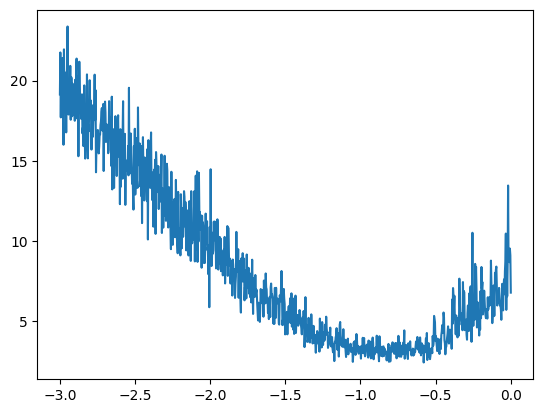

In [135]:
plt.plot(lri, lossi)

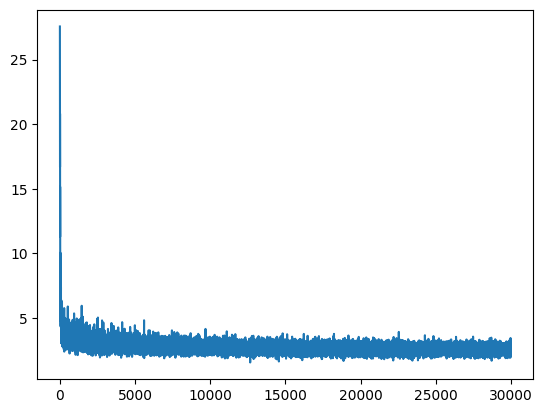

In [20]:
## mini-batch makes noise cuz of random sampling
## large model usually requires larger batch size/ more steps to converge
plt.plot(stepi, lossi)

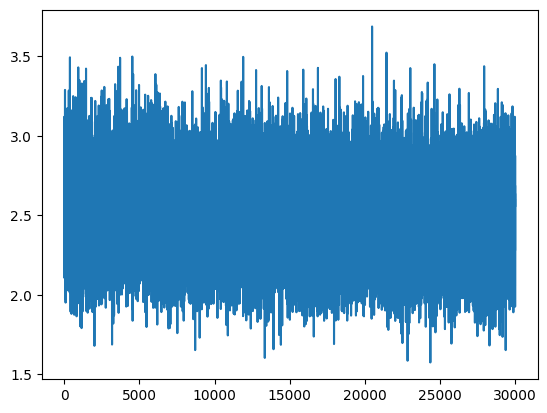

In [24]:
## Not improve much now, try learning decay
## or maybe tiny improvement, but too hard to tell, check vad test loss
plt.plot(stepi, lossi)

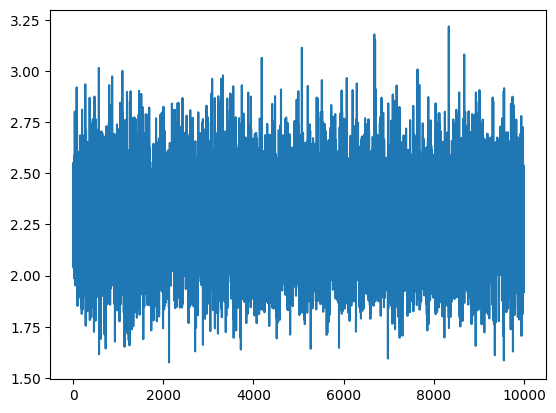

In [31]:
plt.plot(stepi, lossi)

## for 10 size embedding

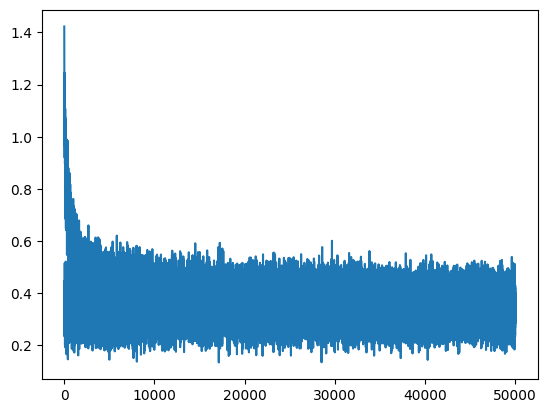

In [61]:
plt.plot(stepi, lossi)

In [62]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, block_size*emb_size) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2142, grad_fn=<NllLossBackward0>)

In [63]:
# training split, dev/validation split, test split
# 80%, 10%, 10%
emb = C[Xte]
h = torch.tanh(emb.view(-1, block_size*emb_size) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2055, grad_fn=<NllLossBackward0>)

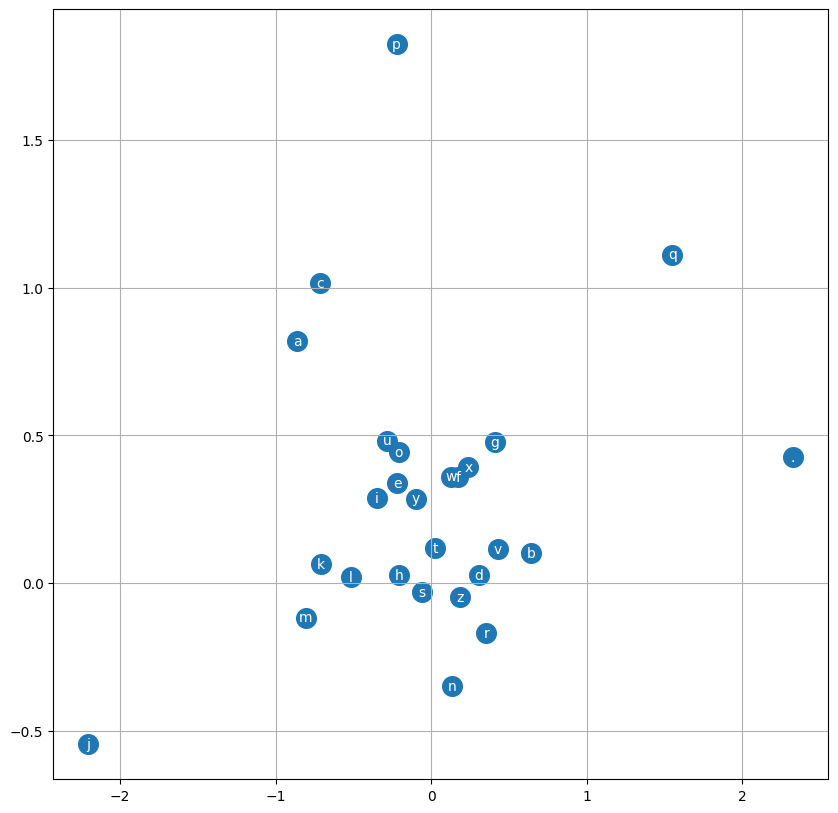

In [64]:
## though hidden layer is much larger, loss doesnt improve much
## maybe the bottleneck is in the embedding layer which size is two
## plot embedding
plt.figure(figsize=(10,10))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [65]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
ambriq.
khi.
mili.
thaydencestie.
rahnen.
den.
rht.
kaeli.
nelmara.
chaiiv.
kaleigh.
ham.
jory.
quinn.
shor.
raiviani.
wanthogdiarynix.
kael.
dura.
